In [ ]:
!pip install pandas networkx py2neo neo4j node2vec faiss-cpu

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving objectclass.csv to objectclass.csv
Saving attributes.csv to attributes.csv
Saving SELinuxRealTE.csv to SELinuxRealTE.csv


In [ ]:
import networkx as nx
import pandas as pd

In [ ]:
# Load CSV files and print their columns
#csv files loaded from: https://github.com/joannsum/selinux-analysis-automation/tree/main/csvinitial_type_enforcement_df = pd.read_csv('SELinuxRealTE.csv')
object_class_df = pd.read_csv('objectclass.csv')
attributes_df = pd.read_csv('attributes.csv')

print("Initial Type Enforcement Columns:", initial_type_enforcement_df.columns)
print("Object Class Columns:", object_class_df.columns)
print("Attributes Columns:", attributes_df.columns)


Initial Type Enforcement Columns: Index(['Source', 'Target', 'ObjectClass', 'Permission'], dtype='object')
Object Class Columns: Index(['Name', 'Permissions'], dtype='object')
Attributes Columns: Index(['1', '2'], dtype='object')


In [ ]:
import networkx as nx

# Create a NetworkX graph
G_train = nx.DiGraph()

# Debug: Print the first few rows of each dataframe
print("Initial Type Enforcement Data (first 5 rows):\n", initial_type_enforcement_df.head())
print("Attributes Data (first 5 rows):\n", attributes_df.head())

Initial Type Enforcement Data (first 5 rows):
              Source                      Target ObjectClass        Permission
0       httpd_php_t                       lib_t        file  execute_no_trans
1         openvpn_t  http_cache_client_packet_t      packet              recv
2         openvpn_t  http_cache_client_packet_t      packet              send
3  systemd_logind_t                  polydomain     process           getattr
4   kern_unconfined                 sysctl_type    lnk_file            append
Attributes Data (first 5 rows):
                               1  \
0       NetworkManager_etc_rw_t   
1          NetworkManager_etc_t   
2         NetworkManager_exec_t   
3  NetworkManager_initrc_exec_t   
4          NetworkManager_log_t   

                                                   2  
0  configfile, file_type, non_auth_file_type, non...  
1  configfile, file_type, non_auth_file_type, non...  
2  application_exec_type, direct_init_entry, entr...  
3  entry_type, exec_t

In [ ]:
# Add nodes and edges from the type enforcement data
for index, row in initial_type_enforcement_df.iterrows():
    source = row['Source']
    target = row['Target']
    object_class = row['ObjectClass']
    permission = row['Permission']
    G_train.add_node(source, label='Type')
    G_train.add_node(target, label='Type')
    G_train.add_edge(source, target, object_class=object_class, permission=permission)

# Add attributes to the nodes
for index, row in attributes_df.iterrows():
    node = row['1']
    attributes = row['2'].split(', ')
    if node in G_train.nodes:
        G_train.nodes[node]['attributes'] = attributes

# Add object class permissions to nodes
for index, row in object_class_df.iterrows():
    obj_class = row['Name']
    permissions = row['Permissions'].split(', ')
    for node in G_train.nodes():
        if G_train.nodes[node].get('object_class') == obj_class:
            G_train.nodes[node]['permissions'] = permissions

# Print the training graph nodes and edges
print("Training graph nodes:", G_train.nodes(data=True))
print("Training graph edges:", G_train.edges(data=True))


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from node2vec import Node2Vec
#Trying to Generate node embeddings using Node2Vec...
#Initialize Node2Vec model
node2vec_train = Node2Vec(G_train, dimensions=64, walk_length=30, num_walks=200, workers=4)

#Generate node embeddings
model_train = node2vec_train.fit(window=10, min_count=1, batch_words=4)

#Save embeddings
embeddings_train = {node: model_train.wv[node] for node in G_train.nodes()}


Computing transition probabilities:   0%|          | 0/4721 [00:00<?, ?it/s]

Sample embedding for node 'httpd_php_t': [-6.0077059e-01  1.2624412e+00  6.6329074e-01 -2.3486604e-01
 -2.7117640e-02 -7.3234953e-02  3.8428552e-02  1.1602613e+00
 -9.3400568e-01  2.4144404e-01  1.6100215e+00  4.2023534e-01
  1.8373679e-01  6.4155626e-01  8.5333192e-01 -2.2673802e-01
 -2.5958899e-02  5.0024515e-01  4.1162723e-01 -6.0138393e-02
  1.1830294e+00 -4.9293309e-01  6.4358634e-01  5.2072056e-02
  9.0261120e-01 -9.3721575e-01 -3.4434497e-01 -2.0696074e-01
  2.3168472e-03  3.5499781e-01 -2.1007393e-01  1.2934551e-01
 -4.5095462e-01 -8.4831679e-01  5.6176656e-01  6.9861341e-01
 -4.3279806e-01 -1.3679823e-01  1.0203922e+00 -4.0896416e-01
 -2.7646089e-01  3.0773755e-02 -5.8253318e-01  6.3450110e-01
  9.5154887e-01  2.8449807e-01  3.2420602e-01 -4.9126503e-01
 -1.3990233e+00 -5.4145414e-02  3.5768262e-01 -2.8089536e-02
 -1.4233436e-01  1.6063888e-01 -1.3634166e-01  1.1217101e-04
  4.0518889e-01 -4.2152655e-01 -2.8373504e-02 -1.6614632e-01
  5.3528339e-01 -7.1923506e-01  3.3426470e-0

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import numpy as np
# using isolation forest to train the anomaly detection model.
# Convert embeddings to a matrix
embedding_matrix_train = np.array([embeddings_train[node] for node in G_train.nodes()])
node_list_train = list(G_train.nodes())

# Standardize the embeddings
scaler_train = StandardScaler()
embedding_matrix_scaled_train = scaler_train.fit_transform(embedding_matrix_train)

# Train Isolation Forest for anomaly detection
iso_forest_train = IsolationForest(contamination=0.1)
iso_forest_train.fit(embedding_matrix_scaled_train)

IsolationForest(contamination=0.1)

In [ ]:
# random example graph for testing anomaly detection:
# Example Type Enforcement CSV for Anomaly Detection
example_type_enforcement_data = {
    'Source': ['new_t1', 'new_t2', 'new_t3', 'new_t4', 'new_t5'],
    'Target': ['new_t6', 'new_t7', 'new_t8', 'new_t9', 'new_t10'],
    'ObjectClass': ['file', 'packet', 'process', 'lnk_file', 'socket'],
    'Permission': ['read', 'send', 'getattr', 'execute', 'connect']
}

example_type_enforcement_df = pd.DataFrame(example_type_enforcement_data)
example_type_enforcement_df.to_csv('example_type_enforcement.csv', index=False)

example_type_enforcement_df = pd.read_csv('example_type_enforcement.csv')

# Debug: Print the first few rows of the example dataframe
print("Example Type Enforcement Data (first 5 rows):\n", example_type_enforcement_df.head())

# Create a NetworkX graph for the example data
G_example = nx.DiGraph()

# Add nodes and edges from the example type enforcement data
for index, row in example_type_enforcement_df.iterrows():
    source = row['Source']
    target = row['Target']
    object_class = row['ObjectClass']
    permission = row['Permission']
    G_example.add_node(source, label='Type')
    G_example.add_node(target, label='Type')
    G_example.add_edge(source, target, object_class=object_class, permission=permission)

# Print the example graph nodes and edges
print("Example graph nodes:", G_example.nodes(data=True))
print("Example graph edges:", G_example.edges(data=True))

Example Type Enforcement Data (first 5 rows):
    Source   Target ObjectClass Permission
0  new_t1   new_t6        file       read
1  new_t2   new_t7      packet       send
2  new_t3   new_t8     process    getattr
3  new_t4   new_t9    lnk_file    execute
4  new_t5  new_t10      socket    connect
Example graph nodes: [('new_t1', {'label': 'Type'}), ('new_t6', {'label': 'Type'}), ('new_t2', {'label': 'Type'}), ('new_t7', {'label': 'Type'}), ('new_t3', {'label': 'Type'}), ('new_t8', {'label': 'Type'}), ('new_t4', {'label': 'Type'}), ('new_t9', {'label': 'Type'}), ('new_t5', {'label': 'Type'}), ('new_t10', {'label': 'Type'})]
Example graph edges: [('new_t1', 'new_t6', {'object_class': 'file', 'permission': 'read'}), ('new_t2', 'new_t7', {'object_class': 'packet', 'permission': 'send'}), ('new_t3', 'new_t8', {'object_class': 'process', 'permission': 'getattr'}), ('new_t4', 'new_t9', {'object_class': 'lnk_file', 'permission': 'execute'}), ('new_t5', 'new_t10', {'object_class': 'socket', 'p

In [ ]:
# Testing example graph
node2vec_example = Node2Vec(G_example, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Generate node embeddings
model_example = node2vec_example.fit(window=10, min_count=1, batch_words=4)

# Save embeddings
embeddings_example = {node: model_example.wv[node] for node in G_example.nodes()}

# Print sample embeddings
print("Sample embedding for node 'new_t1':", embeddings_example['new_t1'] if 'new_t1' in embeddings_example else 'Node not found')


Computing transition probabilities:   0%|          | 0/10 [00:00<?, ?it/s]

Sample embedding for node 'new_t1': [-0.01142641 -0.0152467  -0.00424712 -0.0130976  -0.00957451 -0.00909534
 -0.00368017 -0.00263007 -0.01423001 -0.00113438  0.01294927  0.01211359
 -0.01142839 -0.00570974  0.00488248 -0.01504921  0.00233289  0.01032688
  0.00892792 -0.01391491 -0.0069497  -0.01273761  0.00014257  0.0146379
  0.009535    0.00798257  0.0079075  -0.00504998  0.0149343  -0.01166455
 -0.0116177  -0.00370478 -0.00107936 -0.00516782 -0.00093771  0.01178881
 -0.00098471 -0.00266132  0.00441953 -0.01327955  0.01222267  0.01355267
 -0.01521714  0.00374294  0.01563385 -0.01204567 -0.01105226 -0.01209219
  0.01333462 -0.00104715  0.01437656 -0.01282991  0.00582543  0.00416459
  0.00131313  0.0035917  -0.01179719 -0.01485545  0.00365494  0.0098603
  0.01254043  0.00896441 -0.00131159  0.01300476]


In [ ]:
# Anomaly Detection on Example Graph
embedding_matrix_example = np.array([embeddings_example[node] for node in G_example.nodes()])
node_list_example = list(G_example.nodes())

embedding_matrix_scaled_example = scaler_train.transform(embedding_matrix_example)
anomaly_scores = iso_forest_train.decision_function(embedding_matrix_scaled_example)
anomaly_labels = iso_forest_train.predict(embedding_matrix_scaled_example)

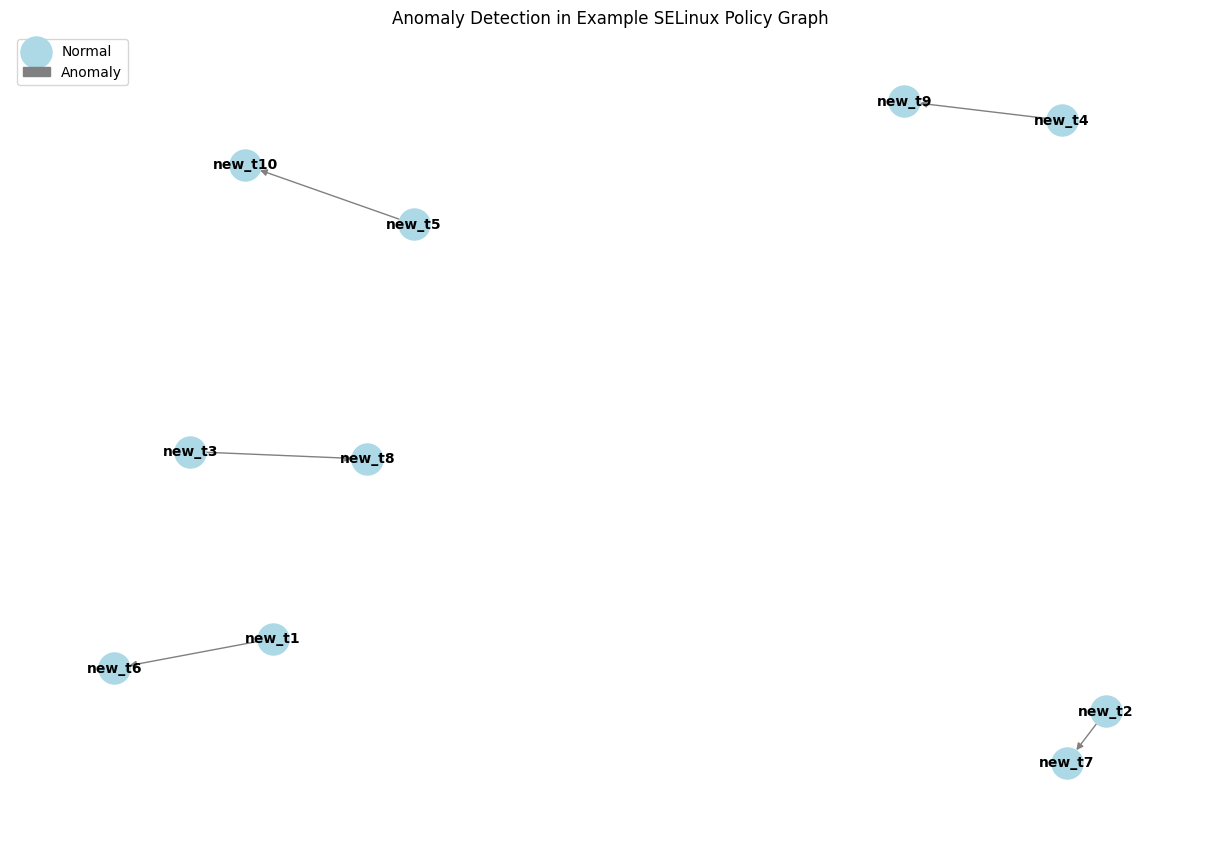

In [ ]:
import matplotlib.pyplot as plt

# plotting out the Anomaly Detection Results
plt.figure(figsize=(12, 8))

# Node layer
pos = nx.spring_layout(G_example)

# Draw the graph with node labels
nx.draw(G_example, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10, font_weight='bold')

# Highlight anomalies
anomaly_nodes = [node for node, label in zip(node_list_example, anomaly_labels) if label == -1]
nx.draw_networkx_nodes(G_example, pos, nodelist=anomaly_nodes, node_color='red', node_size=700)

# Add legend
plt.legend(['Normal', 'Anomaly'], loc='upper left')

plt.title('Anomaly Detection in Example SELinux Policy Graph')
plt.show()